# Training and indexing movie recommender
> Building tensorflow model on movielens latest small variant and indexing using NMSlib for efficient retrieval

- toc: true
- badges: true
- comments: true
- categories: [Tensorflow, Movie, NMSLib]
- author: "<a href='https://github.com/BastienVialla/MovieLens'>Bastien Vialla</a>"
- image:

## Setup

In [43]:
!pip install -q nmslib

     |████████████████████████████████| 13.5MB 189kB/s 
     |████████████████████████████████| 194kB 50.5MB/s 


In [23]:
import re
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
import seaborn as sns
from sklearn.model_selection import train_test_split

from keras.models import load_model, model_from_json
from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Activation, Reshape, Dropout
from keras.layers import Concatenate
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras import optimizers
from pathlib import Path
from sklearn.metrics import mean_squared_error

import nmslib

import warnings
warnings.filterwarnings('ignore')

## Loading data

In [2]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2021-07-02 10:11:40--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  2.67MB/s    in 0.3s    

2021-07-02 10:11:40 (2.67 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [5]:
PATH = "ml-latest-small"
ratings_raw = pd.read_csv(PATH+"/ratings.csv")
ratings_raw.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
movies_raw = pd.read_csv(PATH+"/movies.csv")
movies_raw.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Create dictionnaries to convert ids and indexes

In [7]:
ratings_train = ratings_raw.copy()

users_uniq = ratings_train.userId.unique()
user2idx = {o:i for i,o in enumerate(users_uniq)}
idx2user = {i:o for i,o in enumerate(users_uniq)}
ratings_train.userId = ratings_train.userId.apply(lambda x: user2idx[x])

movies_uniq = ratings_train.movieId.unique()
movie2idx = {o:i for i,o in enumerate(movies_uniq)}
idx2movie = {i:o for i,o in enumerate(movies_uniq)}
ratings_train.movieId = ratings_train.movieId.apply(lambda x: movie2idx[x])

n_users = int(ratings_train.userId.nunique())
n_movies = int(ratings_train.movieId.nunique())

n_users, n_movies

(610, 9724)

In [10]:
def save_obj(obj, name):  
    with open(Path(f"{name}.pkl"), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

save_obj(user2idx, "user2idx")
save_obj(idx2user, "idx2user")
save_obj(movie2idx, "movie2idx")
save_obj(idx2movie, "idx2movie")

## Keras Model
The model works as follows:
1. Embedds the user and movie id.
2. Concanate the user embedding, movie embedding and the weighted rating into one vector.
3. Passes to linear layers with dropout.

The architecture takes as parameters the embedding size, the size of hidden layers, and the dropout probability associate to them.

In [16]:
class MovieNet: 
    def rmse(self, y, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y)))

    def custom_activation(self, x):
        return K.sigmoid(x) * (self.max_rating+1)

    def __init__(self, n_users, n_movies, min_rating=0.5, max_rating=5):
        self.min_rating = min_rating
        self.max_rating = max_rating
        self.n_users = n_users
        self.n_movies = n_movies
        
    def build_model(self, emb_size=[50, 50], hl=[10], drop=[0.25], emb_trainable=True):
        inputs = [Input(shape=(1,)), Input(shape=(1,))] #, Input(shape=(1,))]
        users_emb = Embedding(self.n_users, emb_size[0], name='users', trainable=emb_trainable)(inputs[0])
        movies_emb = Embedding(self.n_movies, emb_size[1], name='movies', trainable=emb_trainable)(inputs[1])
        outputs_emb = [Reshape(target_shape=(emb_size[0],))(users_emb), Reshape(target_shape=(emb_size[1],))(movies_emb)]
        
        output_model = Concatenate()(outputs_emb)
        for i in range(0, len(hl)):
            output_model = Dense(hl[i], kernel_initializer='uniform')(output_model)
            output_model = Activation('relu')(output_model)
            output_model = Dropout(drop[i])(output_model)

        output_model = Dense(1)(output_model)

        output_model = Activation(self.custom_activation)(output_model)
        
        self.model = KerasModel(inputs=inputs, outputs=output_model)
        
        opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
        
        self.model.compile(loss='mse', optimizer=opt, metrics=[self.rmse])
        
          
    def prepare_input(self, _X):
        X = [_X.userId.values, _X.movieId.values]#, _X.ratingWeight]
        return X            
            
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        return mean_squared_error(y, y_pred)
    
    def fit(self, X_train, y_train, X_valid, y_valid, epochs=50, batch_size=32, verbose=1):
        self.model.fit(self.prepare_input(X_train), y_train,
                       validation_data=(self.prepare_input(X_valid), y_valid),
                      epochs=epochs, batch_size=batch_size, verbose=verbose)
        # print("Result on validation data: ", self.evaluate(X_valid, y_valid))
        
    def predict(self, X):
        y_pred = self.model.predict(self.prepare_input(X))
        return y_pred.flatten()

    def save_model(self, path=Path(""), name="MovieModel"):
        self.model.save_weights(f"{path}/{name}_weights.h5")
        with open(f"{path}/{name}_arch.json", 'w') as f:
            f.write(self.model.to_json())
    
    def load_model(self, path=Path(""), name="MovieModel"):
        with open(f"{path}/{name}_arch.json", 'r') as f:
            self.model = model_from_json(f.read(), custom_objects={"custom_activation": self.custom_activation})
        self.model.load_weights(f"{path}/{name}_weights.h5") 

In [17]:
movie_model = MovieNet(n_users, n_movies)
movie_model.build_model(emb_size=[50, 50], hl=[70, 10], drop=[0.4, 0.3])

In [18]:
X = ratings_train.drop(['timestamp', 'rating'], axis=1)
y = ratings_train['rating']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
len(X_train), len(X_valid), len(y_train), len(y_valid)

(80668, 20168, 80668, 20168)

It's important that every movie are in the training set to have trained embedding of each of them.

In [19]:
len(X_train["movieId"].unique()), n_movies, n_movies - len(X_train["movieId"].unique())

(9015, 9724, 709)

In [20]:
miss_movies = ratings_train[~ratings_train.movieId.isin(X_train["movieId"].unique())]["movieId"].unique()

In [21]:
concat = pd.DataFrame()
for i in miss_movies:
    concat = concat.append(ratings_train[ratings_train.movieId == i].sample(1))
    
concat.head()

,userId,movieId,rating,timestamp
291,2,282,4.5,1306464021
292,2,283,5.0,1306463825
294,2,285,5.0,1306463670
637,5,541,3.0,845556241
728,5,614,3.0,845556412


### Train and save model

In [25]:
X_valid.drop(concat.index, axis=0, inplace=True)
y_valid.drop(concat.index, axis=0, inplace=True)

X_train = pd.concat([X_train, concat.drop(["rating", "timestamp"], axis=1)])
y_train = pd.concat([y_train, concat["rating"]])

len(X_train["movieId"].unique()), n_movies

(9724, 9724)

In [26]:
movie_model.fit(X_train, y_train, X_valid, y_valid, epochs=5, batch_size=512)

Epoch 1/5
159/159 [==============================] - 17s 11ms/step - loss: 1.0931 - rmse: 1.0419 - val_loss: 0.7839 - val_rmse: 0.8739
Epoch 2/5
159/159 [==============================] - 1s 7ms/step - loss: 0.7692 - rmse: 0.8765 - val_loss: 0.7445 - val_rmse: 0.8491
Epoch 3/5
159/159 [==============================] - 1s 7ms/step - loss: 0.7151 - rmse: 0.8449 - val_loss: 0.7357 - val_rmse: 0.8435
Epoch 4/5
159/159 [==============================] - 1s 7ms/step - loss: 0.6707 - rmse: 0.8185 - val_loss: 0.7344 - val_rmse: 0.8434
Epoch 5/5
159/159 [==============================] - 1s 8ms/step - loss: 0.6454 - rmse: 0.8027 - val_loss: 0.7376 - val_rmse: 0.8471


In [27]:
movie_model.save_model(name="movie_model")

## Load objects

In [37]:
PATH = 'ml-latest-small'
ratings_raw = pd.read_csv(PATH+"/ratings.csv")
movies_raw = pd.read_csv(PATH+"/movies.csv")

def load_obj(name):  
    with open(Path(f"{name}.pkl"), 'rb') as f:
        return pickle.load(f)

user2idx = load_obj("user2idx")
idx2user = load_obj("idx2user")
movie2idx = load_obj("movie2idx")
idx2movie = load_obj("idx2movie")

ratings = ratings_raw.copy()
ratings["userId"] = ratings["userId"].apply(lambda x: user2idx[x])
ratings["movieId"] = ratings["movieId"].apply(lambda x: movie2idx[x])
ratings.head()

,userId,movieId,rating,timestamp
0,0,0,4.0,964982703
1,0,1,4.0,964981247
2,0,2,4.0,964982224
3,0,3,5.0,964983815
4,0,4,5.0,964982931


In [30]:
movie_model = MovieNet(n_users, n_movies)
movie_model.load_model(name="movie_model")

## Prediction

In [31]:
X_pred = pd.DataFrame({"userId": [0 for _ in range(n_movies)], "movieId": [i for i in range(n_movies)]})

In [32]:
def predict_user(user_id):
    X_pred["userId"] = X_pred.userId.apply(lambda x: user_id)
    preds = movie_model.predict(X_pred)
    df_preds = pd.DataFrame({"pred": preds, "movieId": [i for i in range(n_movies)],
                             "title": [movies_raw.loc[movies_raw.movieId == idx2movie[i]]["title"].values[0] for i in range(n_movies)]})
    return df_preds

def suggest_user(user_id, m=10):
    preds = predict_user(user_id)
    preds.sort_values("pred", ascending=False, inplace=True)
    r = ratings[ratings.userId == 0]["movieId"].values
    preds.drop(r, axis=0, inplace=True)
    return preds.drop("movieId", axis=1)[:m]

def user_rating(user_id):
    preds = predict_user(user_id)
    return pd.merge(ratings[ratings.userId == user_id][["rating", "movieId"]], preds, on="movieId")

In [33]:
user_id = np.random.randint(0, n_users)
user_id

189

In [39]:
preds = user_rating(user_id).sort_values("rating", ascending=False)[:]
preds.head(10)

,rating,movieId,pred,title
32,5.0,763,3.563197,Harry Potter and the Chamber of Secrets (2002)
60,5.0,3149,3.375989,"Life Aquatic with Steve Zissou, The (2004)"
18,5.0,457,3.608593,Harry Potter and the Sorcerer's Stone (a.k.a. ...
48,5.0,1129,4.081214,Eternal Sunshine of the Spotless Mind (2004)
43,5.0,2046,4.013078,Lost in Translation (2003)
51,5.0,779,3.931088,Harry Potter and the Prisoner of Azkaban (2004)
24,5.0,3182,3.747530,And Your Mother Too (Y tu mamá también) (2001)
37,5.0,1146,4.204359,City of God (Cidade de Deus) (2002)
20,5.0,1125,4.156560,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ..."
61,5.0,917,3.701892,Harry Potter and the Half-Blood Prince (2009)


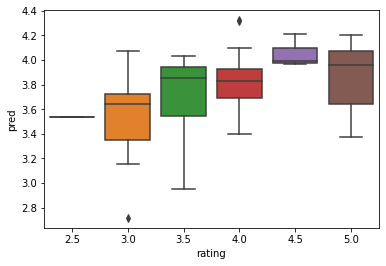

In [40]:
sns.boxplot(preds["rating"], preds["pred"])

In [41]:
suggest_user(user_id)

,pred,title
2158,4.594354,Guess Who's Coming to Dinner (1967)
1395,4.587749,"Three Billboards Outside Ebbing, Missouri (2017)"
2933,4.570197,Love and Death (1975)
8833,4.559479,"Jetée, La (1962)"
3457,4.558405,Raiders of the Lost Ark: The Adaptation (1989)
4750,4.553044,Last Tango in Paris (Ultimo tango a Parigi) (1...
6542,4.540706,Come and See (Idi i smotri) (1985)
3233,4.539537,Five Easy Pieces (1970)
2793,4.522316,"Holy Mountain, The (Montaña sagrada, La) (1973)"
5646,4.521130,"Day of the Doctor, The (2013)"


## Recommanding movies using KNN on embedding spaces

### Looking at movies embedding space

In [45]:
movies_index = nmslib.init(space='angulardist', method='hnsw')
movies_index.addDataPointBatch(movie_model.model.get_layer("movies").get_weights()[0])

M = 100
efC = 1000
efS = 1000
num_threads = 6
index_time_params = {'M': M, 'indexThreadQty': num_threads, 'efConstruction': efC, 'post' : 0}
query_time_params = {'efSearch': efS}

movies_index.createIndex(index_time_params)
movies_index.setQueryTimeParams(query_time_params)

In [46]:
def get_knns(index, vecs, n_neighbour):
     return zip(*index.knnQueryBatch(vecs, k=n_neighbour, num_threads=6))

def get_knn(index, vec, n_neighbour):
    return index.knnQuery(vec, k=n_neighbour)

def suggest_movies_knn(movieId, n_suggest = 5):
    res = get_knn(movies_index, movie_model.model.get_layer("movies").get_weights()[0][movieId], n_suggest)[0]
    return movies_raw[movies_raw.movieId.isin([idx2movie[i] for i in res])]

In [52]:
movie_id = 763
suggest_movies_knn(movie_id, 10)

,movieId,title,genres
867,1147,When We Were Kings (1996),Documentary
1290,1719,"Sweet Hereafter, The (1997)",Drama
1539,2074,"Night Porter, The (Portiere di notte, Il) (1974)",Crime|Drama|Romance
1928,2557,I Stand Alone (Seul contre tous) (1998),Drama|Thriller
2259,2997,Being John Malkovich (1999),Comedy|Drama|Fantasy
4076,5816,Harry Potter and the Chamber of Secrets (2002),Adventure|Fantasy
7275,74727,Gentlemen of Fortune (Dzhentlmeny udachi) (1972),Comedy|Crime|Drama|Mystery
8525,114678,Hector and the Search for Happiness (2014),Adventure|Comedy|Drama
9572,174141,Belladonna of Sadness (1973),Animation|Drama|Fantasy
9680,183317,Patti Rocks (1988),Comedy|Drama


### Looking at users embedding space

In [53]:
users_index = nmslib.init(space='angulardist', method='hnsw')
users_index.addDataPointBatch(movie_model.model.get_layer("users").get_weights()[0])

M = 100
efC = 1000
efS = 1000
num_threads = 6
index_time_params = {'M': M, 'indexThreadQty': num_threads, 'efConstruction': efC, 'post' : 0}
query_time_params = {'efSearch': efS}

users_index.createIndex(index_time_params)
users_index.setQueryTimeParams(query_time_params)

In [ ]:
def suggest_users_knn(user_id, n_suggest = 5):
    res = get_knn(users_index, movie_model.model.get_layer("users").get_weights()[0][user_id], n_suggest)[0]
    for uid in res[1:]:
        moviesId = ratings[ratings.userId == uid].sort_values("rating", ascending=False)[:10]["movieId"].values
        print("From user", uid, ": ")
        display(movies_raw[movies_raw.movieId.isin([idx2movie[i] for i in moviesId])])

In [54]:
suggest_users_knn(user_id)

From user 353 : 


,movieId,title,genres
507,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi
832,1093,"Doors, The (1991)",Drama
926,1225,Amadeus (1984),Drama
1617,2161,"NeverEnding Story, The (1984)",Adventure|Children|Fantasy
1916,2541,Cruel Intentions (1999),Drama
2020,2692,Run Lola Run (Lola rennt) (1998),Action|Crime
3562,4878,Donnie Darko (2001),Drama|Mystery|Sci-Fi|Thriller
3622,4973,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",Comedy|Romance
4615,6874,Kill Bill: Vol. 1 (2003),Action|Crime|Thriller
5943,34319,"Island, The (2005)",Action|Sci-Fi|Thriller


From user 553 : 


,movieId,title,genres
142,170,Hackers (1995),Action|Adventure|Crime|Thriller
785,1028,Mary Poppins (1964),Children|Comedy|Fantasy|Musical
827,1088,Dirty Dancing (1987),Drama|Musical|Romance
836,1097,E.T. the Extra-Terrestrial (1982),Children|Drama|Sci-Fi
898,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
911,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
914,1213,Goodfellas (1990),Crime|Drama
926,1225,Amadeus (1984),Drama
975,1276,Cool Hand Luke (1967),Drama
2035,2710,"Blair Witch Project, The (1999)",Drama|Horror|Thriller


From user 455 : 


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
543,640,Diabolique (1996),Drama|Thriller
552,662,Fear (1996),Thriller
592,733,"Rock, The (1996)",Action|Adventure|Thriller
615,780,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller
645,832,Ransom (1996),Crime|Thriller
1052,1367,101 Dalmatians (1996),Adventure|Children|Comedy
1073,1393,Jerry Maguire (1996),Drama|Romance
1083,1407,Scream (1996),Comedy|Horror|Mystery|Thriller


From user 320 : 


,movieId,title,genres
1,2,Jumanji (1995),Adventure|Children|Fantasy
116,141,"Birdcage, The (1996)",Comedy
126,153,Batman Forever (1995),Action|Adventure|Comedy|Crime
275,316,Stargate (1994),Action|Adventure|Sci-Fi
276,317,"Santa Clause, The (1994)",Comedy|Drama|Fantasy
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War
337,380,True Lies (1994),Action|Adventure|Comedy|Romance|Thriller
418,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
510,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
630,802,Phenomenon (1996),Drama|Romance
